In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tikzplotlib

%run './../split_step_fourier.ipynb'
DEBUG = False
DEBUG_PLOT = True

# showing figures inline
%matplotlib inline
# plotting options 
figure_size = (16, 9)
plt.rcParams.update({
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

In [2]:
# parameters
f_symbol = 32e9  # symbol rate (Baud) (Symbols per second)

r_rc = .33
syms_per_filt = 4  # symbols per filter (plus minus in both directions)

P_in = 19 # dBm

# modulation scheme and constellation points
M = 2
modulation = {'0': -1, '1': 1}
n_symbol = 30 # number of symbols

# Signalfolge generieren
send_bits = np.random.choice([symbol for symbol in modulation.keys()], size=n_symbol)

In [3]:
## Transmission parameters
z_length = 70  # [km]
nz = 10  # steps
dz = z_length / nz

alpha = 0.2  # Dämpfung [dB/km]
D = 17  # [ps/nm/km]
beta2 = - (D * np.square(1550e-9)) / (2 * np.pi * 3e8) * 1e-3 # [s^2/km] propagation constant, lambda=1550nm is standard single-mode wavelength
gamma = 1.3 # [1/W/km]

In [4]:
## Simulation
n_up_max = 16  # samples per symbol (>1 => oversampling)

outputs = {}
sampletimes = {}

for n_up in range(1, n_up_max+1):
    # Pulse IR
    t_sample, ir  = get_rc_ir(syms_per_filt, r_rc, f_symbol, n_up)
    # Sendesignal generieren
    send_ir = generate_signal(modulation, t_sample, 1/f_symbol, send_bits, ir, syms_per_filt, P_in)
    # add zeros before and after signal (use samples per symbol as factor)
    send = zeroing(send_ir, 10 * int(1/f_symbol/t_sample))
    # transmission
    output = splitstepfourier(send, t_sample, dz, nz, alpha, beta2, gamma)

    outputs[f"{n_up}"] = output
    sampletimes[f"{n_up}"] = t_sample
    

Text(0.5, 0, '$t[s]$')

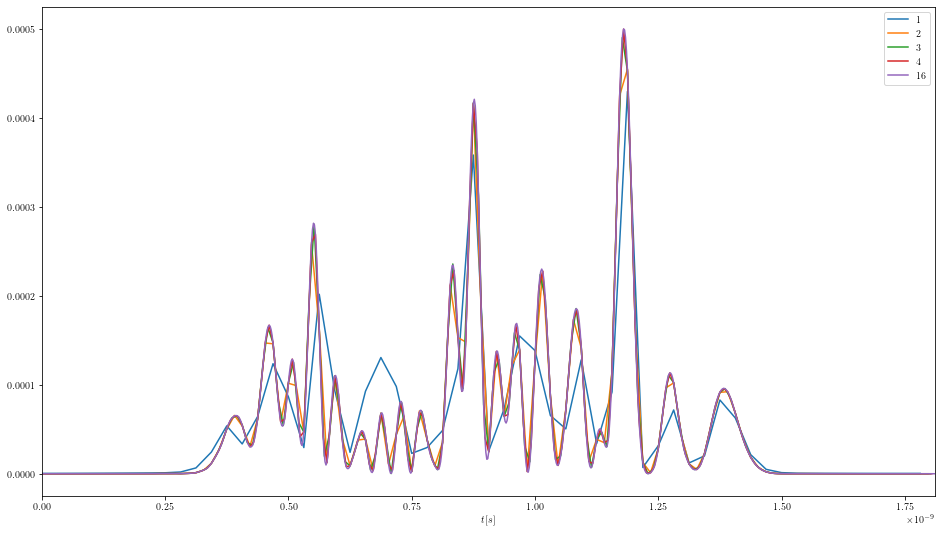

In [5]:
fig1, ax1 = plt.subplots(1, figsize=figure_size)

for key, item in outputs.items():
    if key in ['1', '2', '3', '4', '16']:
        x_vals = np.arange(item.size)*sampletimes[key]
        ax1.plot(x_vals, np.square(np.abs(item)), label=key)
        ax1.set_xlim(np.amin(x_vals), np.amax(x_vals))
    
ax1.legend()
ax1.set_xlabel("$t[s]$")

(5e-10, 7.5e-10)

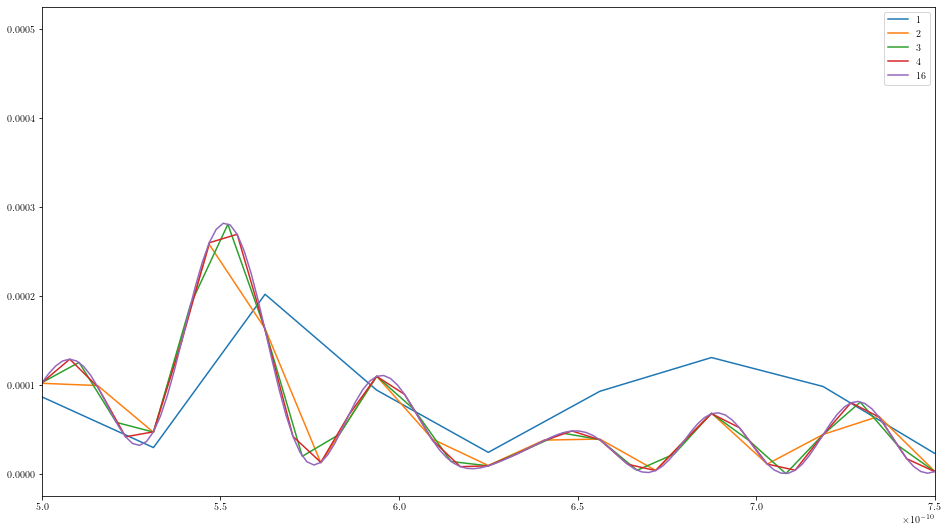

In [6]:
fig2, ax2 = plt.subplots(1, figsize=figure_size)

for key, item in outputs.items():
    if key in ['1', '2', '3', '4', '16']:
        x_vals = np.arange(item.size)*sampletimes[key]
        ax2.plot(x_vals, np.square(np.abs(item)), label=key)
    
ax2.legend()
ax2.set_xlim(0.5e-9, 0.75e-9)

In [7]:
output_fname = "oversampling"
output_path = "../../../bachelorarbeit-ausarbeitung/figures/plots/"

tikzplotlib.save(f'{output_path}{output_fname}_full.tex', figure=fig1, wrap=False, add_axis_environment=False, externalize_tables=True, override_externals=True)
tikzplotlib.save(f'{output_path}{output_fname}_zoom.tex', figure=fig2, wrap=False, add_axis_environment=False, externalize_tables=True, override_externals=True)

fig1.savefig(f"{output_path}{output_fname}_full.pdf", bbox_inches='tight')
fig2.savefig(f"{output_path}{output_fname}_zoom.pdf", bbox_inches='tight')